In [ ]:
from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
import os

file = Path(r"G:\MeOH_test\Mie\T2_Mie Camera_1.cine")
json_file = Path(r"G:\MeOH_test\Mie\config.json")
out_dir = Path(r"G:\MeOH_test\Mie\Processed_Results")

umbrella_angle=180.0
# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file)

F, H, W = video.shape

# Normalize the grayscale video to [0, 1] brightness range
video = video / brightness_levels

with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)

print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 401
The injector has 1 plumes.
The nozzle is centred at (604.00, 82.00) in image coordinates.


In [3]:
from OSCC_postprocessing.playback.video_playback import *
play_video_cv2(video, intv=17)

In [4]:
# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )

In [5]:
# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


(604.0, 82.0)

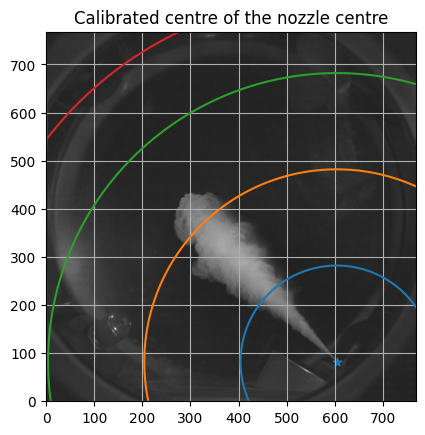

In [6]:
rs = np.asarray([200, 400, 600, or_])

# Displaying the clibration
plt.imshow(video[50]**0.5, cmap="gray")
plt.scatter(centre[0], centre[1], marker="*")

for r in rs:
    theta = np.linspace(0, 2*np.pi, 400)

    x0, y0 = centre[0] , centre[1]

    x = x0 + r * np.cos(theta)
    y = y0 + r * np.sin(theta)

    plt.plot(x, y, linewidth="1.5")


# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([max(0, centre[0]-1.1*r), min(W, centre[0]+1.1*r)])
plt.ylim([max(0, centre[1]-1.1*r), min(H, centre[1]+1.1*r)])
plt.title("Calibrated centre of the nozzle centre")
centre

In [7]:
# Rotation


# Frames, Height, Width
F, H, W = video.shape

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (or_//3, or_)

video = cp.asarray(video)

segment, _, _ = rotate_video_nozzle_at_0_half_backend(
        video,
        centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
        # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
        offset,
        interpolation=INTERPOLATION,
        border_mode=BORDER_MODE,
        out_shape=OUT_SHAPE,
    )




In [8]:
play_video_cv2(segment.get(), intv=17)
segment.shape

(401, 253, 760)

In [9]:
from OSCC_postprocessing.filters.bilateral_filter import *
# upload to gpu or do nothing with cpu

# pakaged pre-processing calling, use this in real impelmentations
# foreground = pre_processing_mie(video, division=False)

# Explicitly coding for showing the whole process

# We do not divide by the first frame to fix lighting
# In the videos I process, they have some strong bright spots by reflections
# If didivde, they become some dark spots. 


# For single plume, rotate & crop before filtering 

# Bilateral filtering
if use_gpu:
    bilateral_filtered = bilateral_filter_video_cupy(segment, 7, 3, 3)
else:
    bilateral_filtered = bilateral_filter_video_cpu(np.asarray(segment), 7, 3, 3)



# Take the filtered first frame as background 
bkg = bilateral_filtered[0]
bkg[bkg == 0] = 1e-9
bkg[bkg == cp.nan] = 1e-9

# Foreground is the filtered video - filtered background
foreground = bilateral_filtered - bilateral_filtered[0][None, :, :]
F, H, W = foreground.shape

In [10]:
# play_video_cv2(foreground.get())

play_videos_side_by_side((
    cp.swapaxes(segment, 1, 2).get(),
    cp.swapaxes(foreground, 1, 2).get(),
    cp.swapaxes(10.0*cp.abs(foreground-segment), 1, 2).get()
), intv=17)
segment.shape

(401, 253, 760)

In [11]:
td_map = xp.sum(foreground, axis=1).T
td_map.shape

(760, 401)

(760, 401)

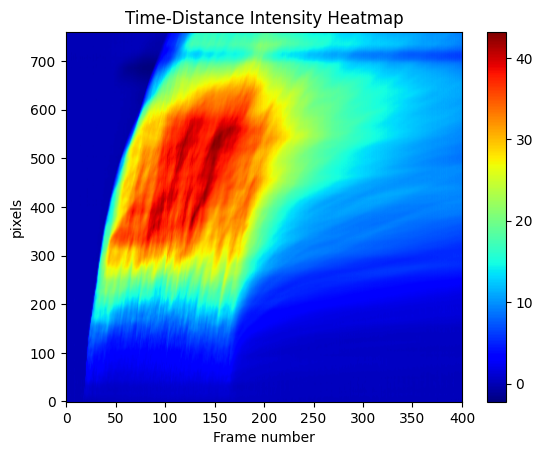

In [12]:
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")
td_map.shape

In [13]:
frame_wise_sums = xp.sum(td_map, axis=0)/td_map.shape[0]

brightness_peak = xp.argmax(frame_wise_sums)

peak_intensity_sum = xp.max(frame_wise_sums)


Text(0.5, 0, 'Frame Number')

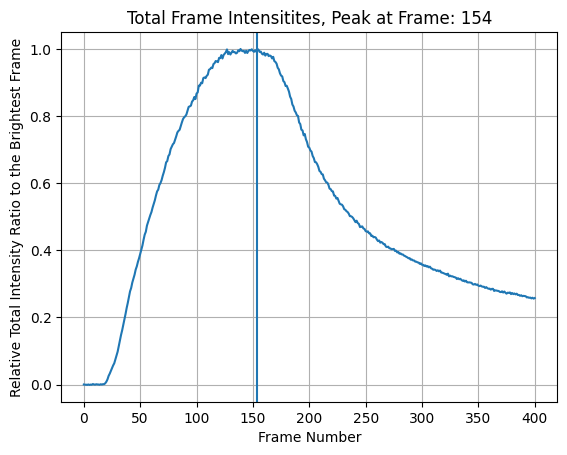

In [14]:
ratio = frame_wise_sums.get()/peak_intensity_sum.get()
plt.plot(ratio)
plt.grid()
plt.axvline(brightness_peak.get())
plt.title(f"Total Frame Intensitites, Peak at Frame: {brightness_peak}")
plt.ylabel("Relative Total Intensity Ratio to the Brightest Frame")
plt.xlabel("Frame Number")


Text(0, 0.5, 'Gain')

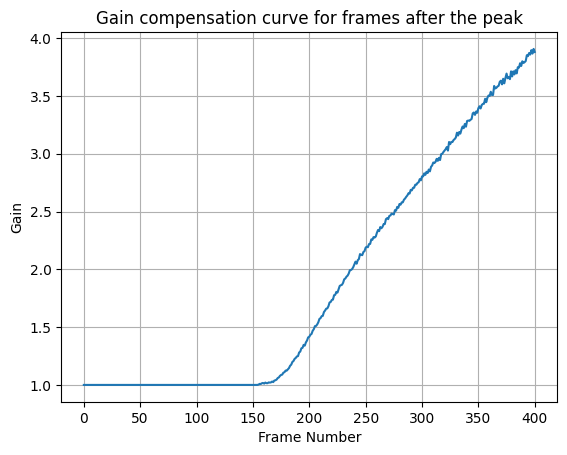

In [15]:
gain_curve = 1.0 / (1e-9 + ratio.astype(xp.float64))

gain_curve[:int(brightness_peak)] = 1.0


plt.plot(gain_curve)
plt.title("Gain compensation curve for frames after the peak")
plt.grid()
plt.xlabel("Frame Number")
plt.ylabel("Gain")

In [16]:
foreground[int(brightness_peak):] *= xp.asarray(gain_curve[int(brightness_peak):, None, None])

td_map[:, int(brightness_peak):] *= xp.asarray(gain_curve[None,  int(brightness_peak):])

In [17]:
play_video_cv2(foreground.get())

(760, 401)

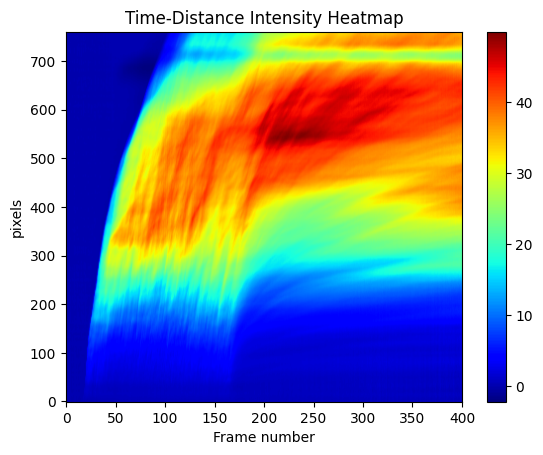

In [18]:
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")
td_map.shape

In [19]:
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.analysis.multihole_utils import * 

bw =  keep_largest_component_cuda(
        triangle_binarize_gpu(
            _min_max_scale(td_map))
            , connectivity=2)

Text(0.5, 0, 'Frame number')

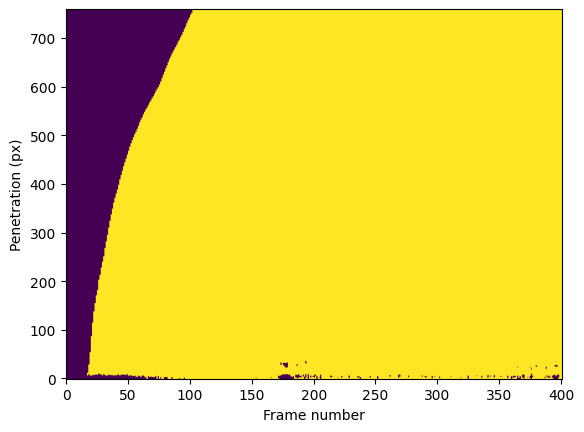

In [20]:
plt.imshow(bw.get(), origin="lower", aspect="auto")
plt.ylabel("Penetration (px)")

plt.xlabel("Frame number")


In [21]:
def longest_true_run(mask):
    """返回最长 True 连续段的 (start, end_exclusive)，若无 True 返回 None。"""
    """Retruan the longest True duration"""
    m = mask.astype(bool)
    if not m.any():
        return None
    diff = np.diff(m.astype(np.int8))
    starts = np.where(diff == 1)[0] + 1
    ends   = np.where(diff == -1)[0] + 1
    if m[0]:
        starts = np.r_[0, starts]
    if m[-1]:
        ends = np.r_[ends, len(m)]
    lengths = ends - starts
    k = np.argmax(lengths)
    return int(starts[k]), int(ends[k])

In [22]:
import pandas as pd

df = pd.DataFrame()

In [23]:


penetration_TD = bw.shape[0] - cp.argmax(bw[::-1, :], axis=0)
penetration_TD = penetration_TD.astype(cp.float32)
penetration_TD[penetration_TD == bw.shape[0]] = cp.nan

TF = ~cp.isnan(penetration_TD)

start, end = longest_true_run(TF.get())

penetration_TD[:start] = 0.0
penetration_TD[end:] = cp.nan

df["Penetration_from_TD"] = penetration_TD.get()

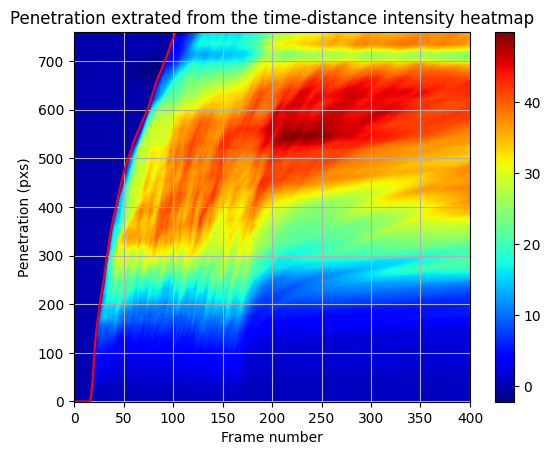

In [24]:
plt.plot(penetration_TD.get(), color="r")
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.colorbar()
plt.grid()

In [25]:
# Cone angle
# We set the origin to the nozzle, and treat upper and lower half as two plumes
# Then calculate their cone angle by angular density respectively

_, signal, _ = angle_signal_density_auto(foreground, 0.0, H//2, N_bins=3600)
AngularDensity = compute_cone_angle_from_angular_density(signal, 0, 2, bins=3600, use_gpu=True)

# Upper & Lower cone angle, sums up to the total cone angle
cone_angle_AD_up = AngularDensity[0]
cone_angle_AD_down = AngularDensity[1]
cone_angle_AD = cone_angle_AD_up + cone_angle_AD_down
ad_up_np = to_numpy(cone_angle_AD_up)
ad_down_np = to_numpy(cone_angle_AD_down)

df["Cone_Angle_Angular_Density"] =cone_angle_AD
df["Cone_Angle_Angular_Density_Upper"] = ad_up_np
df["Cone_Angle_Angular_Density_Lower"] = ad_down_np



Text(0, 0.5, 'Frame number')

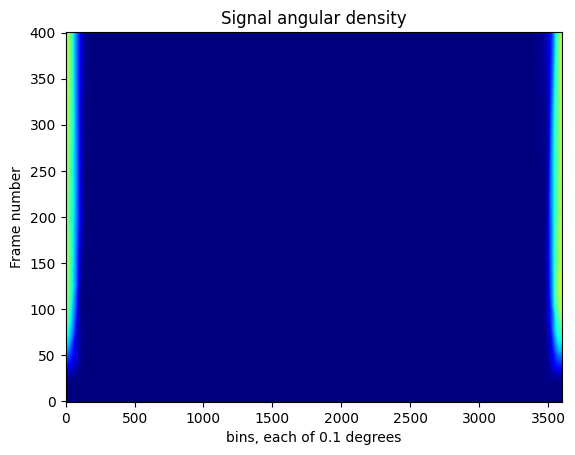

In [26]:
bins = 3600
plt.imshow(signal, aspect="auto", origin="lower", cmap="jet")
plt.title("Signal angular density")
plt.xlabel(f"bins, each of {360.0/bins} degrees")
plt.ylabel("Frame number")

Text(0, 0.5, 'Cone Angle (Degrees)')

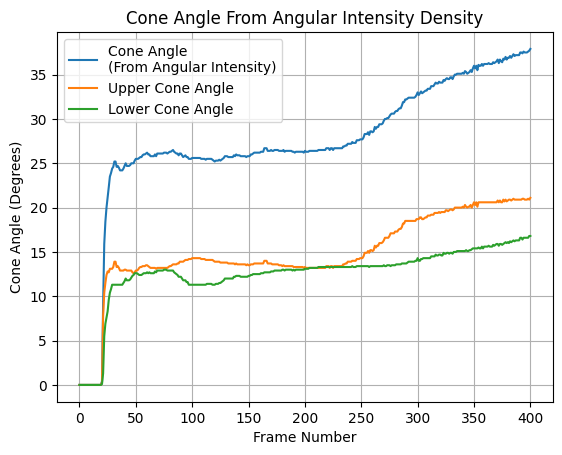

In [27]:
plt.plot(cone_angle_AD, label="Cone Angle\n(From Angular Intensity)")
plt.plot(ad_down_np, label="Upper Cone Angle") 
plt.plot(ad_up_np, label="Lower Cone Angle")

plt.grid()
plt.title("Cone Angle From Angular Intensity Density")
plt.legend()
plt.xlabel("Frame Number")
plt.ylabel("Cone Angle (Degrees)")


In [28]:
# Nozzle Opening and Closing

# Window Size in the left center of the video
height = 1.0/20
width = 1.0/20

F, H, W = segment.shape
near_nozzle_intensity_sums = xp.sum(segment[ :, int(H//2 - H*height//2):int(H//2 + H*height//2), :int(W*width)], axis=(1, 2))


In [29]:
play_video_cv2(segment[ :, int(H//2 - H*height//2):int(H//2 + H*height//2), :int(W*width)].get())

In [30]:
import numpy as np

def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med)) + 1e-12

def hysteresis_threshold(y, th_lo, th_hi):
    """
    滞回阈值：>th_hi 触发进入 high；<th_lo 退出 high。
    
    Hysteresis threshold:  
        When the value > th_hi, triggers high state;
        when the value < th_lo, exits high state
        """
    high = y > th_hi
    low  = y < th_lo

    mask = np.zeros_like(y, dtype=bool)
    state = False
    for i in range(len(y)):
        if not state:
            if high[i]:
                state = True
        else:
            if low[i]:
                state = False
        mask[i] = state
    return mask

def fill_short_false_runs(mask, max_len=3):
    """
    把 mask 中短的 False 段填成 True（填洞）。
    Filling short False pulses into True (hole-filling)
    """
    m = mask.copy()
    # 找 False runs
    diff = np.diff(m.astype(np.int8))
    starts = np.where(diff == -1)[0] + 1  # True->False 后 False 段开始
    ends   = np.where(diff ==  1)[0] + 1  # False->True 后 False 段结束
    if m[0] == False:
        starts = np.r_[0, starts]
    if m[-1] == False:
        ends = np.r_[ends, len(m)]
    for s, e in zip(starts, ends):
        if (e - s) <= max_len:
            m[s:e] = True
    return m

def remove_short_true_runs(mask, min_len=5):
    """把 mask 中短的 True 段删掉（去小岛）。"""
    """Filling up short True pulses with False (removing islands)"""
    m = mask.copy()
    diff = np.diff(m.astype(np.int8))
    starts = np.where(diff == 1)[0] + 1
    ends   = np.where(diff == -1)[0] + 1
    if m[0] == True:
        starts = np.r_[0, starts]
    if m[-1] == True:
        ends = np.r_[ends, len(m)]
    for s, e in zip(starts, ends):
        if (e - s) < min_len:
            m[s:e] = False
    return m

def longest_true_run(mask):
    """返回最长 True 连续段的 (start, end_exclusive)，若无 True 返回 None。"""
    """Retruan the longest True duration"""
    m = mask.astype(bool)
    if not m.any():
        return None
    diff = np.diff(m.astype(np.int8))
    starts = np.where(diff == 1)[0] + 1
    ends   = np.where(diff == -1)[0] + 1
    if m[0]:
        starts = np.r_[0, starts]
    if m[-1]:
        ends = np.r_[ends, len(m)]
    lengths = ends - starts
    k = np.argmax(lengths)
    return int(starts[k]), int(ends[k])

def detect_single_high_interval(y, x=None,
                                base_quantile=0.50,
                                scale_quantile=0.10,
                                k_hi=8.0, k_lo=4.0,
                                fill_hole_len=3,
                                min_island_len=5):
    """
    y: 1D 信号
    x: 可选真实坐标；不传则用索引
    阈值：th_hi = base + k_hi * sigma, th_lo = base + k_lo * sigma
    sigma 用 MAD 估计（鲁棒）

    y: 1D signal,
    x: Can accecpt real coordinates, 
    """
    y = np.asarray(y)
    if x is None:
        x = np.arange(len(y))
    else:
        x = np.asarray(x)

    # 1) 基线与尺度（鲁棒）
    base = np.quantile(y, base_quantile)
    sigma = 1.4826 * mad(y - base)  # MAD->std 等效（对高斯噪声）
    th_hi = base + k_hi * sigma
    th_lo = base + k_lo * sigma

    # 2) 滞回二值化
    mask = hysteresis_threshold(y, th_lo=th_lo, th_hi=th_hi)

    # 3) 清理：填洞 + 去小岛
    mask = fill_short_false_runs(mask, max_len=fill_hole_len)
    mask = remove_short_true_runs(mask, min_len=min_island_len)

    # 4) 只保留最长段
    run = longest_true_run(mask)
    if run is None:
        return None, mask, (th_lo, th_hi)

    s, e = run
    # 输出坐标：起点 x[s]，终点 x[e-1]（最后一个 True 的点）
    return (x[s], x[e-1], s, e-1), mask, (th_lo, th_hi)

In [31]:
import numpy as np
import cupy as cp

Lo_Hi = cp.zeros_like(near_nozzle_intensity_sums, dtype=cp.bool_)

# num_cases, N = near_nozzle_intensity_sums.shape

# hydraulic_delay = np.zeros(num_cases, dtype=np.float32)
# nozzle_closing = np.zeros(num_cases, dtype=np.float32)


y =_min_max_scale( near_nozzle_intensity_sums.T.get() / (height* H * width*W)) # cupy -> numpy
res, mask, _ = detect_single_high_interval(y)

if res is None:
    hydraulic_delay = np.nan
    nozzle_closing = np.nan
    Lo_Hi[:] = False
else:    

    (hd, nc, _, _) = res   # 这里 hd/nc 是 x_start/x_end（如果你 x=None）
    hydraulic_delay = hd
    nozzle_closing = nc

    Lo_Hi = cp.asarray(mask, dtype=cp.bool_)

In [32]:
df["Hydraulic_Delay"] = hydraulic_delay
df["Nozzle Closing"] = nozzle_closing


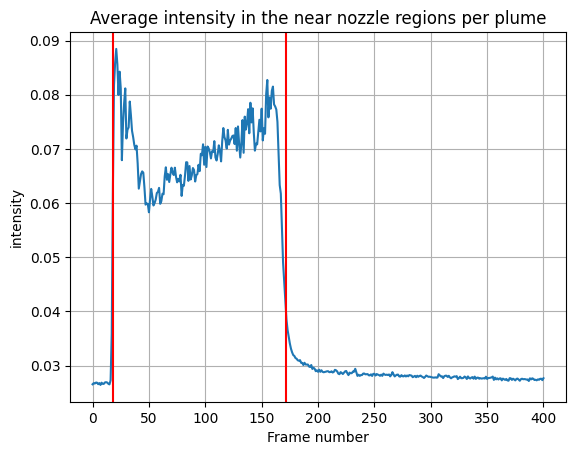

In [33]:
plt.plot(near_nozzle_intensity_sums.T.get() / (height* H * width*W))
plt.axvline(hd, color="r")
plt.axvline(nc, color="r")
plt.title("Average intensity in the near nozzle regions per plume")
plt.xlabel("Frame number")
plt.ylabel("intensity")
plt.grid()

In [34]:
df.head()

,Penetration_from_TD,Cone_Angle_Angular_Density,Cone_Angle_Angular_Density_Upper,Cone_Angle_Angular_Density_Lower,Hydraulic_Delay,Nozzle Closing
0,0.0,0.0,0.0,0.0,18,172
1,0.0,0.0,0.0,0.0,18,172
2,0.0,0.0,0.0,0.0,18,172
3,0.0,0.0,0.0,0.0,18,172
4,0.0,0.0,0.0,0.0,18,172


In [35]:
from OSCC_postprocessing.analysis.single_plume import _binary_fill_holes_gpu
bw_video = _binary_fill_holes_gpu(
    keep_largest_component_nd_cuda(
        triangle_binarize_gpu(foreground)
        , connectivity=2),
        mode="2D"
    )


In [36]:
play_video_cv2(((1-bw_video)*foreground).get()*10.0)


In [ ]:
area = bw_video.sum(axis=(1, 2))


bw_video_col_sum = bw_video.sum(axis=1)


penetration_bw_x = penetration_bw_to_index(bw_video_col_sum > 0)



In [ ]:
# Volume estimation

if umbrella_angle == 180.0:
    x_scale=1.0
else:
    tilt_angle = (180.0-umbrella_angle)/2.0
    tilt_angle_rad = tilt_angle / 180.0 * np.pi
    x_scale = 1.0/np.cos(tilt_angle_rad)

estimated_volume = x_scale * 0.25 * np.pi * np.sum(bw_video_col_sum**2, axis=1)

upper_bw_width = bw_video[:, : H // 2, :].sum(axis=1)
lower_bw_width = bw_video[:, H // 2 :, :].sum(axis=1)

max_plume_radius = np.maximum(upper_bw_width, lower_bw_width)
min_plume_radius = np.minimum(upper_bw_width, lower_bw_width)

estimated_volume_max =  x_scale * np.sum(np.pi * max_plume_radius**2, axis=1)
estimated_volume_min =  x_scale * np.sum(np.pi * min_plume_radius**2, axis=1)


In [38]:
from OSCC_postprocessing.analysis.single_plume import bw_boundaries_all_points_single_plume
boundary = bw_boundaries_all_points_single_plume(bw_video, parallel=True)

Text(0.5, 1.0, 'Scattered boundary points at slected frames')

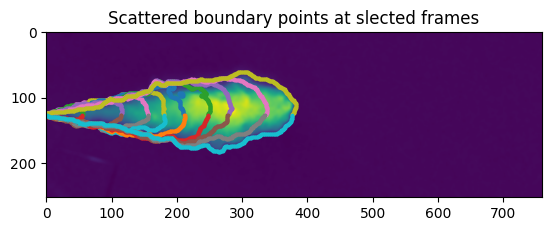

In [61]:
selected_frames = [17, 19, 21, 23, 25, 27, 30, 32, 36, 40]
for f in selected_frames:
    up = boundary[f][0]
    down = boundary[f][1]
    plt.scatter(up[:, 1], up[:, 0]+ H//2, s=3)
    plt.scatter(down[:, 1], down[:, 0]+ H//2, s=3)


# plt.xlim([0, W])
# plt.ylim([-H//2, H//2])
plt.imshow(foreground[selected_frames[-1]].get())
plt.title(f"Scattered boundary points at slected frames")


In [40]:
penetration_old_polar = np.zeros(F)
for i in range(F):
    pts = boundary[i]
    if len(pts[0]) > 0 and len(pts[1]) > 0:

        uy, ux = pts[1][:, 0], pts[1][:, 1]
        ly, lx = pts[0][:, 0], pts[0][:, 1]

        max_r_upper = np.max(np.sqrt(uy**2 + ux**2))
        max_r_lower = np.max(np.sqrt(ly**2 + lx**2))
        penetration_old_polar[i] = max(max_r_upper, max_r_lower)

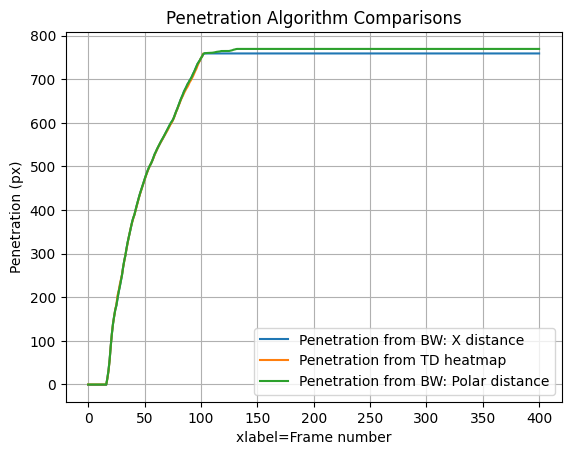

In [41]:
plt.plot(penetration_bw_x.get(), label="Penetration from BW: X distance")
plt.plot(penetration_TD.get(), label="Penetration from TD heatmap")
plt.plot(penetration_old_polar, label="Penetration from BW: Polar distance")
plt.title("Penetration Algorithm Comparisons")
plt.xlabel("xlabel=Frame number")
plt.ylabel("Penetration (px)")
plt.grid()
plt.legend()


In [80]:
points_all_frames = bw_boundaries_xband_filter_single_plume(boundary, penetration_bw_x.get())


Text(0.5, 1.0, 'Scattered boundary points at slected frames')

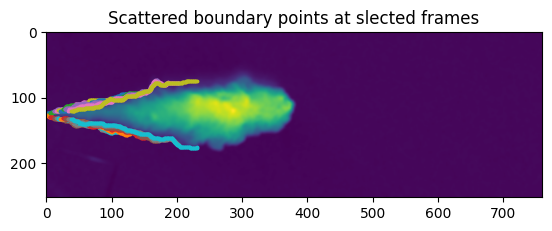

In [67]:
plt.imshow(foreground[selected_frames[-1]].get())

for f in selected_frames:
    up = points_all_frames[f][0]
    down = points_all_frames[f][1]
    # print(up)
    plt.scatter(up[:, 1], up[:, 0]+ H//2, s=3)
    plt.scatter(down[:, 1], down[:, 0]+ H//2, s=3)


# plt.xlim([0, W])
# plt.ylim([-H//2, H//2])

plt.title(f"Scattered boundary points at slected frames")

In [78]:
cone_angle_linear_regression = np.full(F, np.nan)
cone_angle_ransac = np.full(F, np.nan)
cone_angle_average = np.full(F, np.nan)
avg_up = np.full(F, np.nan)
avg_low = np.full(F, np.nan)
ransac_up = np.full(F, np.nan)
ransac_low = np.full(F, np.nan)
lg_up = np.full(F, np.nan)
lg_low = np.full(F, np.nan)

for i in range(F):
    points = points_all_frames[i]
    if len(points[0]) > 0 and len(points[1]) > 0:
        uy, ux = points[1][:, 0], points[1][:, 1]
        ly, lx = points[0][:, 0], points[0][:, 1]

        # uy -= H // 2
        # ly -= H // 2

        ang_up = np.atan(uy / ux) * 180.0 / np.pi
        ang_low = np.atan(ly / lx) * 180.0 / np.pi

        avg_up[i] = np.nanmean(ang_up)
        avg_low[i] = np.nanmean(ang_low)
        cone_angle_average[i] = avg_up[i]-  avg_low[i]

        try:
            ransac_up[i] = np.atan(ransac_fixed_intercept(ux, uy, 0)[0]) * 180.0 / np.pi
            ransac_low[i] = np.atan(ransac_fixed_intercept(lx, ly, 0)[0]) * 180.0 / np.pi
            cone_angle_ransac[i] = ransac_up[i] - ransac_low[i]
        except RuntimeError:
            pass

        try:
            lg_up[i] = np.atan(linear_regression_fixed_intercept(ux, uy, 0.0)) * 180.0 / np.pi
            lg_low[i] = np.atan(linear_regression_fixed_intercept(lx, ly, 0.0)) * 180.0 / np.pi
            cone_angle_linear_regression[i] = lg_up[i] - lg_low[i]
        except ValueError:
            pass

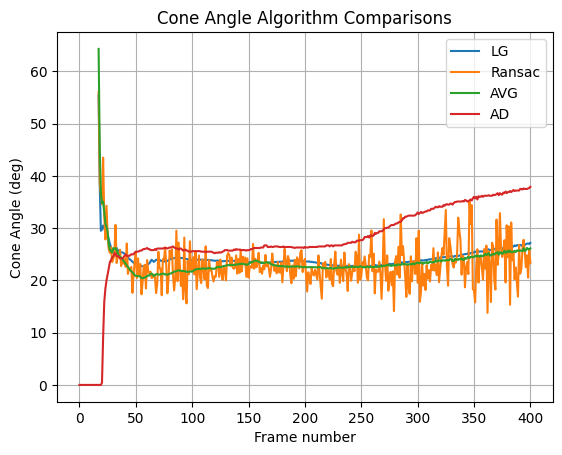

In [81]:
plt.plot(cone_angle_linear_regression, label="LG")
plt.plot(cone_angle_ransac, label="Ransac")
plt.plot(cone_angle_average, label="AVG")
plt.plot(cone_angle_AD, label="AD")
plt.title("Cone Angle Algorithm Comparisons")
plt.xlabel("Frame number")
plt.ylabel("Cone Angle (deg)")
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Area')

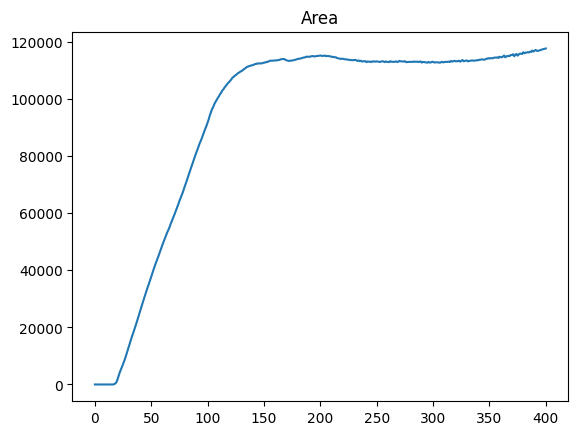

In [87]:
plt.plot(area.get())
plt.title("Area")

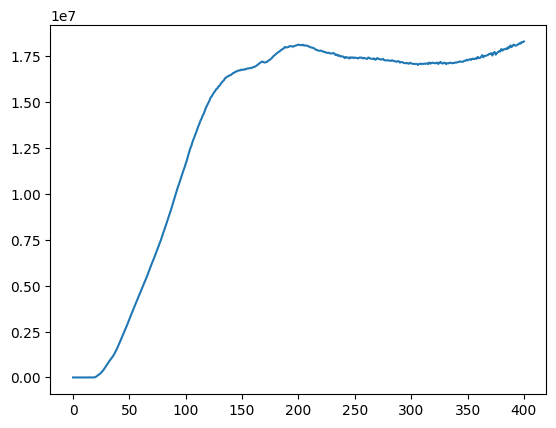

In [89]:
plt.plot(estimated_volume.get())